In [53]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn import tree
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.model_selection import learning_curve, KFold, GridSearchCV
from sklearn.decomposition import PCA




# Librerías adicionales
import itertools  # Para generar combinaciones de columnas
import matplotlib.patches as mpatches  # Para manejar gráficos

# Importación de módulo personalizado
import payments_manager as pm

# Inicialización del proyecto (si es necesario)
# pm.help()  # Si se necesita ayuda del módulo
# pm.reset()  # Para reiniciar cualquier configuración anterior
# pm.init()  # Si es necesario inicializar el módulo con opciones (por ejemplo, debug=True)

# Cargar y preparar el DataFrame df_jo
df_jo = pm.df('df_jo')  # Cargar el DataFrame desde 'payments_manager'
df_jo.info()  # Ver información básica sobre el DataFrame

# Ordenar el DataFrame df_jo por la columna 'id_cr' y resetear índices
df_jo = df_jo.sort_values(by=["id_cr"]).reset_index(drop=True)

# Crear una copia del DataFrame para su posterior uso
df_jo_cp = df_jo.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         32092 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     32092 non-null  object         
 11  transfer_type               32092 non-nul

In [54]:
# PASAJE DE CATEGORICAS A NUMERICAS Y OTROS

# Reasignar valores en la columna 'transfer_type' y 'charge_moment' y 'category'
df_jo_cp = pd.get_dummies(df_jo_cp, columns= ['transfer_type','charge_moment','category'], drop_first=True, dtype=int)


In [55]:
# SEGMENTACIONES EN DATAFRAMES REPETITIVOS Y NUEVOS

# Ordenar por 'created_at' para asegurar que la primera acción esté en la parte superior
df_jo_cp_sorted = df_jo_cp.sort_values('created_at')
count_all = df_jo_cp_sorted.shape[0]

# 2. Identificar usuarios con más de una acción (usuarios repetitivos)

repeat_users_df = df_jo_cp[(df_jo_cp['n_fees'] > 1) | (df_jo_cp['n_backs'] > 1) | (df_jo_cp['n_recovery'] > 1) | (df_jo_cp['n_inc_back'] > 1)| (df_jo_cp['n_inc_fees'] > 1)]

# Sort and group by user_id, keeping repetitive activities
repeat_users_df = repeat_users_df.sort_values('created_at').reset_index(drop=True)

# Obtener los usuarios nuevos (aquellos con solo una acción)

new_users_df = df_jo_cp[(df_jo_cp['n_fees'] <= 1) & (df_jo_cp['n_backs'] <= 1) & (df_jo_cp['n_recovery'] <= 1) & (df_jo_cp['n_inc_back'] <= 1) & (df_jo_cp['n_inc_fees'] <= 1)]


new_users_df = new_users_df.sort_values('created_at').groupby('user_id').first().reset_index()

# Número de filas de nuevos usuarios
count_new_users = new_users_df.shape[0]

# Número de filas de usuarios repetitivos
count_repeat_users = repeat_users_df.shape[0]

# Imprimir resultados
print(f'Número de filas en el DataFrame original: {count_all}')
print(f'Número de filas en el DataFrame de nuevos usuarios: {count_new_users}')
print(f'Número de filas en el DataFrame de usuarios repetitivos: {count_repeat_users}')





Número de filas en el DataFrame original: 32092
Número de filas en el DataFrame de nuevos usuarios: 11938
Número de filas en el DataFrame de usuarios repetitivos: 18809


In [56]:
#VERIFICACION DE BALANCEO DE CLASES

# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
value_counts_all = df_jo_cp['needs_m_check_recov'].value_counts()
value_counts_new = new_users_df['needs_m_check_recov'].value_counts()
value_counts_rep = repeat_users_df['needs_m_check_recov'].value_counts()

# Calcular el total de operaciones (suma de las dos categorías)
total_all = value_counts_all[0] + value_counts_all[1]
total_new = value_counts_new[0] + value_counts_new[1]
total_rep = value_counts_rep[0] + value_counts_rep[1]

# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
needs_manual_all = (value_counts_all[1] / total_all) * 100
needs_manual_new = (value_counts_new[1] / total_new) * 100
needs_manual_rep = (value_counts_rep[1] / total_rep) * 100

# Imprimir el resultado
print(f'Porcentaje de operaciones con needs_m_check del total de clientes: {needs_manual_all:.2f} %')
print(f'Porcentaje de operaciones con needs_m_check del clientes nuevos: {needs_manual_new:.2f} %')
print(f'Porcentaje de operaciones con needs_m_check del clientes repetitivos: {needs_manual_rep:.2f} %')

Porcentaje de operaciones con needs_m_check del total de clientes: 52.31 %
Porcentaje de operaciones con needs_m_check del clientes nuevos: 43.74 %
Porcentaje de operaciones con needs_m_check del clientes repetitivos: 57.83 %


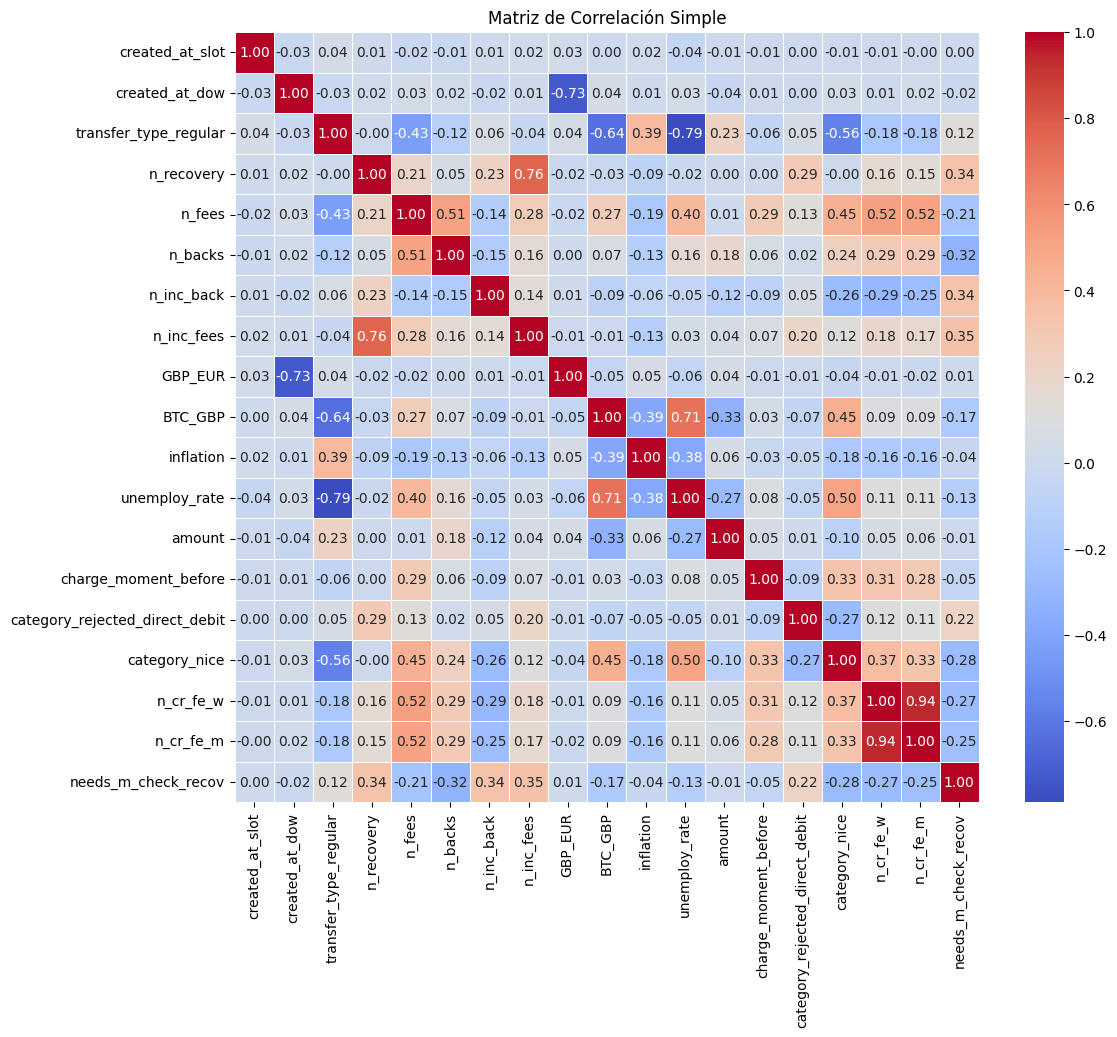

In [57]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas = ['created_at_slot', 'created_at_dow' ,'transfer_type_regular','n_recovery', 'n_fees', 'n_backs','n_inc_back','n_inc_fees','GBP_EUR','BTC_GBP','inflation', 'unemploy_rate','amount','charge_moment_before','category_rejected_direct_debit','category_nice','n_cr_fe_w','n_cr_fe_m','needs_m_check_recov']

# Crear un nuevo DataFrame solamente con esas columnas
df_simpl = df_jo_cp_sorted[columnas_deseadas]
#df_simpl = new_users_df[columnas_deseadas]
#df_simpl = repeat_users_df[columnas_deseadas]

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()


In [58]:
# BALANCEO DE CARGAS

columns = df_simpl.columns
X_b = df_simpl.drop('needs_m_check_recov', axis=1)
y_b = df_simpl['needs_m_check_recov']

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X_b, y_b)

columns_X = np.delete(columns, 18)
columns_y = columns[-1]

print(pd.Series(y_under).value_counts())

X_b_df = pd.DataFrame(X_under, columns=columns_X)
y_b_df = pd.DataFrame(y_under, columns=[columns_y])
X_b_df.fillna(0, inplace=True)

balanced_df = pd.concat([X_b_df, y_b_df], axis=1)
#balanced_df.fillna(0, inplace=True)

needs_m_check_recov
0    15304
1    15304
Name: count, dtype: int64


In [59]:
# NORMALIZACION Y ESCALADO

# Eliminar las columnas no necesarias del DataFrame


X_s = balanced_df.drop(columns=[
    'needs_m_check_recov',
])

# Definir la variable objetivo
Y_s = balanced_df['needs_m_check_recov']

# Aplicar StandardScaler para la normalización
s_scaler = StandardScaler()
X_s_scaled = s_scaler.fit_transform(X_s)

# Convertir el array escalado de nuevo a DataFrame y restaurar los nombres de las columnas
X_s_scaled = pd.DataFrame(X_s_scaled, columns=X_s.columns)

# Imprimir las formas de los datos
print(X_s_scaled.shape)
print(Y_s.shape)

(30608, 18)
(30608,)


In [66]:
# PREPARACION DE CARACTERISTICAS Y ETIQUETA PARA MODELOS

# Crea la matriz de características y la var objetivo
X = balanced_df.drop(columns=[
    'needs_m_check_recov',  
    #   'created_at_slot',      
    #   'created_at_dow',       
    #   'transfer_type_regular',
    #   'n_fees',
    #  'n_backs',
    #   'n_inc_back',
    #  'n_inc_fees',
    #   'GBP_EUR',
    #   'BTC_GBP',
    #   'inflation',      
    #   'unemploy_rate',
    #   'amount',
    #   'charge_moment_before',
    #   'category_rejected_direct_debit',
    #   'category_nice',
    #  'n_cr_fe_w',
    #  'n_cr_fe_m',
    #  'n_recovery',
    ])

#X = X_s.drop(columns=[
    #  'created_at_slot',      
    #  'created_at_dow',       
    #  'transfer_type',
    #  'n_fees',
    #  'n_backs',
    #  'n_inc_back',
    #  'n_inc_fees',
    #  'GBP_EUR',
    #  'BTC_GBP',
    #  'inflation',      
    #  'unemploy_rate',
    #  'amount',
    #  'charge_moment'
    #  'n_recovery"
#])

y = balanced_df['needs_m_check_recov'] # La columna de la variable objetivo
#y = Y_s


X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30608 entries, 1 to 8354
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   created_at_slot                 30608 non-null  int32  
 1   created_at_dow                  30608 non-null  int32  
 2   transfer_type_regular           30608 non-null  int64  
 3   n_recovery                      30608 non-null  int64  
 4   n_fees                          30608 non-null  int64  
 5   n_backs                         30608 non-null  int64  
 6   n_inc_back                      30608 non-null  int64  
 7   n_inc_fees                      30608 non-null  int64  
 8   GBP_EUR                         30608 non-null  float64
 9   BTC_GBP                         30608 non-null  float64
 10  inflation                       30608 non-null  float64
 11  unemploy_rate                   30608 non-null  float64
 12  amount                          30608 

In [67]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# MODELO DE ÁRBOL DE DECISIÓN/RANDOM FOREST

RF = RandomForestClassifier(
    # n_estimators=50,            # Número de árboles en el bosque
    # max_depth=10,                # Profundidad máxima de los árboles
    # min_samples_split=5,        # Mínimo número de muestras requeridas para dividir un nodo interno
    # min_samples_leaf=2,          # Mínimo número de muestras requeridas en una hoja
    # max_features='sqrt',         # Número máximo de características consideradas en cada división 
    # criterion='entropy',          # Métrica para medir la calidad de las divisiones
)


# Entrenar el modelo con el conjunto de datos de entrenamiento
RF.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
predictions = RF.predict(X_test)



In [69]:
# Importancia de las características
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': RF.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)

                           Feature  Importance
7                       n_inc_fees    0.244252
16                       n_cr_fe_w    0.146199
17                       n_cr_fe_m    0.134060
3                       n_recovery    0.123340
5                          n_backs    0.100161
6                       n_inc_back    0.055901
4                           n_fees    0.042582
15                   category_nice    0.024104
13            charge_moment_before    0.023760
14  category_rejected_direct_debit    0.019120
9                          BTC_GBP    0.018207
0                  created_at_slot    0.014440
8                          GBP_EUR    0.012004
2            transfer_type_regular    0.011673
11                   unemploy_rate    0.008892
10                       inflation    0.008370
1                   created_at_dow    0.007479
12                          amount    0.005455


Precisión del modelo: 0.9758

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      3124
           1       0.97      0.98      0.98      2998

    accuracy                           0.98      6122
   macro avg       0.98      0.98      0.98      6122
weighted avg       0.98      0.98      0.98      6122



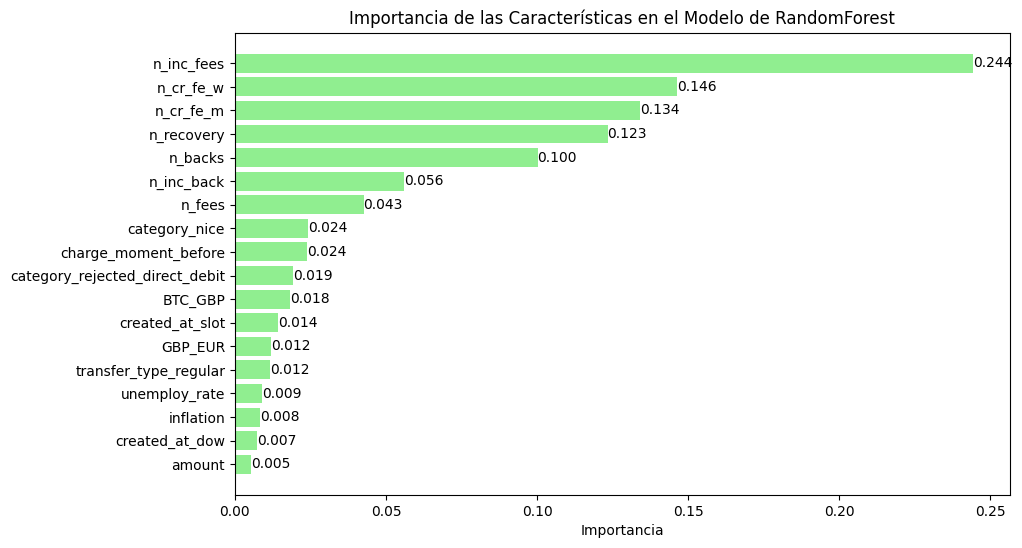

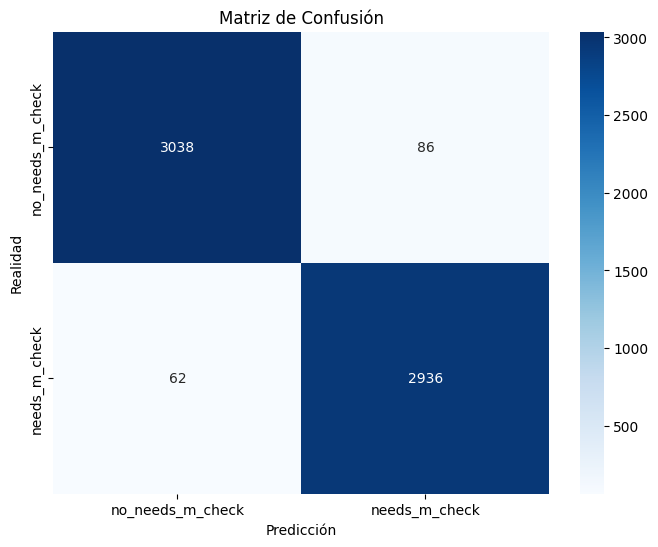

In [70]:
# EVALUACION DEL RENDIMIENTO DEL MODELO

# 1. Precisión del modelo
accuracy = RF.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.4f}")  # Precisión en el conjunto de prueba

# 2. Reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(y_test, predictions))  
# Muestra el reporte con métricas como precisión, recall, f1-score para cada clase

# 3. Importancia de las características

# Obtener las importancias y nombres de las características
importances = RF.feature_importances_
features = X_train.columns

# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]  # Orden descendente
sorted_features = [features[i] for i in indices]
sorted_importances = importances[indices]

# Verificación de tamaño para evitar errores de índice
assert len(sorted_features) == len(sorted_importances), "Mismatch in feature and importance length"

# Graficar
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_features, sorted_importances, color='lightgreen')
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Importancia de las Características en el Modelo de RandomForest")

# Añadir etiquetas con valores numéricos
for bar, value in zip(bars, sorted_importances):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', ha='left', va='center')

plt.show()

# 5. Matriz de confusión

# Nombres de las clases para la matriz de confusión
columnas = ['no_needs_m_check', 'needs_m_check']  # 0 = No, 1 = Sí

# Visualización de la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues', 
            xticklabels=columnas, yticklabels=columnas)

# Personalización de los ejes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()


Total de muestras disponibles: 30608, usando hasta 5000 muestras.
Iteración 1/5
Iteración 2/5
Iteración 3/5
Iteración 4/5
Iteración 5/5


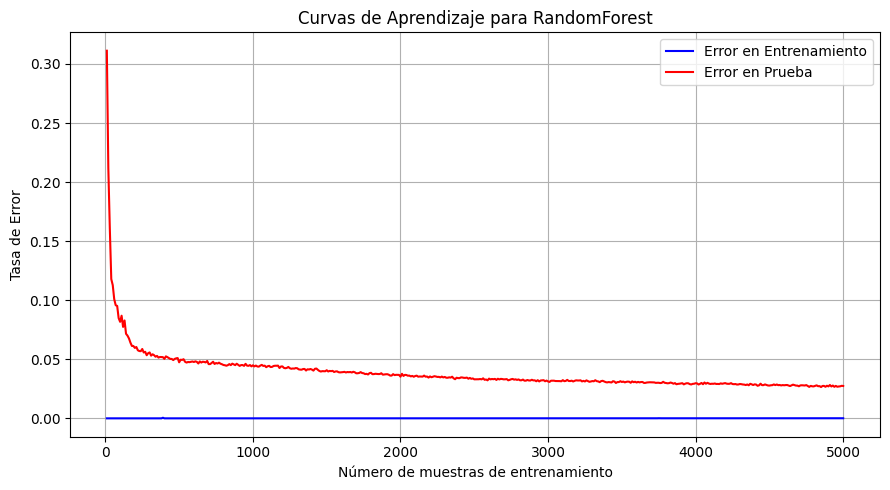

In [71]:
%matplotlib inline

# Graficar curvas de error. 

# Parametros
MAXN = min(len(X), 5000)  # Máximo de muestras a usar
steps = 10               # Incremento de tamaño del conjunto de entrenamiento
iterations = 5             # Iteraciones para suavizar resultados

print(f"Total de muestras disponibles: {len(X)}, usando hasta {MAXN} muestras.")

# Inicializar DataFrames para errores
cols = list(range(steps, MAXN + 1, steps))
test_errors = pd.DataFrame(0.0, index=range(iterations), columns=cols)
train_errors = pd.DataFrame(0.0, index=range(iterations), columns=cols)

# Calcular errores
for iteration in range(iterations):
    print(f"Iteración {iteration+1}/{iterations}")
    data = pd.concat([X, y], axis=1).sample(frac=1, random_state=iteration).reset_index(drop=True)
    X_shuffled, y_shuffled = data[X.columns], data[y.name]

    for N in cols:
        X_subset, y_subset = X_shuffled.iloc[:N, :], y_shuffled.iloc[:N]
        RF.fit(X_subset, y_subset)

        train_pred = RF.predict(X_subset)
        test_pred = RF.predict(X_test)

        train_errors.at[iteration, N] = float(1 - accuracy_score(y_subset, train_pred))
        test_errors.at[iteration, N] = float(1 - accuracy_score(y_test, test_pred))

# Promediar errores
mean_train_error = train_errors.mean(axis=0)
mean_test_error = test_errors.mean(axis=0)

# Graficar curvas de error
plt.figure(figsize=(9, 5))
plt.plot(mean_train_error, 'b-', label='Error en Entrenamiento')
plt.plot(mean_test_error, 'r-', label='Error en Prueba')
plt.xlabel('Número de muestras de entrenamiento')
plt.ylabel('Tasa de Error')
plt.title('Curvas de Aprendizaje para RandomForest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 



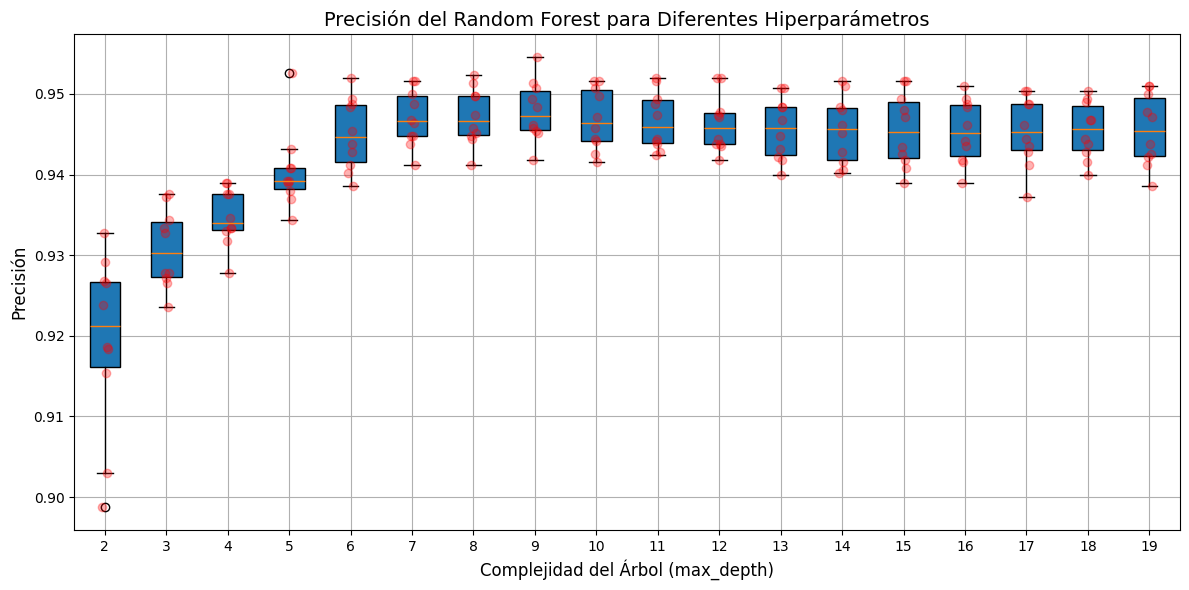

In [51]:
# GRAFICOS DE BOXPLOTS PARA BUSCAR LA PROFUNDIDAD OPTIMA

X_np = X.to_numpy()
y_np = y.to_numpy()

# Configurar la validación cruzada de 10 pliegues
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Definir los hiperparámetros a evaluar
C = np.arange(2, 20)

# Matriz para almacenar las precisiones
results = np.zeros((10, len(C)))

# Iterar sobre los pliegues y los hiperparámetros
for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
    X_train, X_val = X_np[train_idx], X_np[val_idx]
    y_train, y_val = y_np[train_idx], y_np[val_idx]
    for i, c in enumerate (C):

        RF = RandomForestClassifier(
            n_estimators=50,            # Número de árboles en el bosque
            max_depth=c,                # Profundidad máxima de los árboles
            min_samples_split=5,        # Mínimo número de muestras requeridas para dividir un nodo interno
            min_samples_leaf=2,          # Mínimo número de muestras requeridas en una hoja
            max_features='sqrt',         # Número máximo de características consideradas en cada división 
            criterion='entropy',          # Métrica para medir la calidad de las divisiones
        )



        # Entrenar el modelo
        RF.fit(X_train, y_train)

        # Predecir resultados
        y_pred = RF.predict(X_val)

        # Calcular y almacenar la precisión
        results[fold, i] = accuracy_score(y_val, y_pred)

# Graficar los resultados
plt.figure(figsize=(12, 6))

plt.boxplot(results, vert=True, patch_artist=True, meanline=True)

# Superponer los puntajes de precisión individuales para cada nivel de complejidad.
for i, c in enumerate(C):  # Usar el valor de C en lugar del índice.
    xderiv = (i + 1) * np.ones(results[:, i].shape) + (np.random.rand(10,) - 0.5) * 0.1
    plt.plot(xderiv, results[:, i], 'ro', alpha=0.3)  # 'ro' indica marcadores de círculo rojo.

# Establecer etiquetas para el eje x con los valores reales de C.
plt.xticks(ticks=np.arange(1, len(C) + 1), labels=C)
plt.xlabel('Complejidad del Árbol (max_depth)', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.title('Precisión del Random Forest para Diferentes Hiperparámetros', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Definir los hiperparámetros a probar y sus valores
param_grid = {
    'n_estimators': [50, 100, 200, 500],         # Número de árboles
    'max_depth': [None, 10, 20, 30],       # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],       # Mínimas muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],         # Mínimas muestras en una hoja
    'max_features': ['sqrt', 'log2'],      # Número máximo de características para cada división
    'class_weight': ['balanced', None],     # Peso para manejar desbalanceo
    'criterion': ['gini', 'entropy']       # Criterio para medir la calidad de las divisiones
}


# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=RF, 
    param_grid=param_grid, 
    cv=10,                 # Validación cruzada con 10 pliegues
    scoring='f1_weighted', # Utilizamos F1 ponderado como métrica de evaluación
    return_train_score=True, 
    verbose=1,            # Mostrar el progreso
    n_jobs=-1             # Usar todos los núcleos disponibles
)

# Realizar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

results = grid_search.cv_results_

df_results = pd.DataFrame(results)

df_results['overfitting_gap'] = df_results['mean_train_score'] - df_results['mean_test_score']

df_results_sorted = df_results.sort_values(
    by=['mean_test_score', 'overfitting_gap'], 
    ascending=[False, True]  # High test score, small gap
)


print(df_results_sorted[['param_class_weight','param_criterion','param_max_depth','param_max_features','param_min_samples_leaf','param_min_samples_split','param_n_estimators', 'mean_train_score', 'mean_test_score', 'overfitting_gap']].head(10))

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits
    param_class_weight param_criterion param_max_features  \
376           balanced         entropy               sqrt   
101           balanced            gini               sqrt   
423           balanced         entropy               log2   
428           balanced         entropy               log2   
691               None            gini               log2   
975               None         entropy               log2   
950               None         entropy               sqrt   
409           balanced         entropy               log2   
429           balanced         entropy               log2   
80            balanced            gini               sqrt   

     param_min_samples_leaf  param_min_samples_split  param_n_estimators  \
376                       2                        5                  50   
101                       4                        5                 100   
423                       4      

In [43]:
print(df_results_sorted[['param_class_weight','param_criterion','param_max_depth','param_max_features','param_min_samples_leaf','param_min_samples_split','param_n_estimators', 'mean_train_score', 'mean_test_score', 'overfitting_gap']].head(10))

    param_class_weight param_criterion param_max_depth param_max_features  \
376           balanced         entropy              10               sqrt   
101           balanced            gini              10               sqrt   
423           balanced         entropy              10               log2   
428           balanced         entropy              10               log2   
691               None            gini              10               log2   
975               None         entropy              10               log2   
950               None         entropy              10               sqrt   
409           balanced         entropy              10               log2   
429           balanced         entropy              10               log2   
80            balanced            gini              10               sqrt   

     param_min_samples_leaf  param_min_samples_split  param_n_estimators  \
376                       2                        5                  50   
